**R-CNN implimetation**                                                         
In this notebook we will learn to impliment R-CNN network on airplane detection task, using some of the popular deep-learning frameworks.  

**Mounting Gdrive** --
In the below tab we are going to mount our google drive to reach particular directories and load data


Changing Working Directory to Directory where data is stored

We will start by loading in the packages

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Run this cell to set the path and annot to the address of your image folder and Airplanes_Annotations folder.

In [2]:
path = "data/training_images/"
annot = "annotations"

Our airplane dataset contains two parts   
1) Image part-> Contain pictures of airplanes   
2) Airplanes_Annotations-> Contain information about bounding boxes for the pictures available.     
The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `Index` below and re-run to see different examples.

In [3]:
annotations = pd.read_csv('data/bounding_boxes.csv')


In [4]:
annotations_final = pd.DataFrame({'image': annotations['image'], 'boxes': annotations['xmin'].astype(int).astype(str) + ' ' + annotations['ymin'].astype(int).astype(str) + ' ' + annotations['xmax'].astype(int).astype(str) + ' ' + annotations['ymax'].astype(int).astype(str)})
group = annotations_final.groupby(['image'])


In [5]:
print(group.groups)

{'vid_4_1000.jpg': [0], 'vid_4_10000.jpg': [1], 'vid_4_10020.jpg': [3], 'vid_4_10040.jpg': [2], 'vid_4_10060.jpg': [4], 'vid_4_10100.jpg': [5], 'vid_4_10120.jpg': [6], 'vid_4_10140.jpg': [7], 'vid_4_1020.jpg': [8], 'vid_4_1040.jpg': [9], 'vid_4_10480.jpg': [10], 'vid_4_10500.jpg': [11], 'vid_4_10520.jpg': [12], 'vid_4_1060.jpg': [13], 'vid_4_10960.jpg': [14], 'vid_4_10980.jpg': [15], 'vid_4_11000.jpg': [16], 'vid_4_11020.jpg': [17], 'vid_4_11240.jpg': [18], 'vid_4_11260.jpg': [19], 'vid_4_11280.jpg': [20], 'vid_4_11380.jpg': [21], 'vid_4_11400.jpg': [22], 'vid_4_11420.jpg': [23], 'vid_4_11440.jpg': [24], 'vid_4_11880.jpg': [26], 'vid_4_11900.jpg': [25], 'vid_4_11920.jpg': [27], 'vid_4_11940.jpg': [28], 'vid_4_11960.jpg': [29], 'vid_4_11980.jpg': [30], 'vid_4_12000.jpg': [31], 'vid_4_12040.jpg': [32], 'vid_4_12060.jpg': [34], 'vid_4_12080.jpg': [35], 'vid_4_12100.jpg': [33], 'vid_4_12120.jpg': [36], 'vid_4_12140.jpg': [37, 38], 'vid_4_12160.jpg': [39, 40, 41], 'vid_4_12180.jpg': [42, 43

In [6]:
# for name, g in group:
#     g.drop(columns=['image'], inplace=True)
#     g.rename(columns=g.count(), inplace=True)
#     print(g)
    # break
    

In [7]:
for name, g in group:    
    g.drop(columns=['image'], inplace=True)
    g.rename(columns=g.count(), inplace=True)
    g.to_csv(f"annotations/{name.split('.')[0]}.csv", index=False)
    

/var/folders/9n/kzdbb24d6718p004k3bbjtr40000gn/T/ipykernel_10224/267160229.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, g in group:


In [8]:
for e,i in enumerate(os.listdir(annot)):
    print(i.split('.'))
    print(i)
    print(e)
    print(os.path.join(annot,i))

    break

['vid_4_30000', 'csv']
vid_4_30000.csv
0
annotations/vid_4_30000.csv


vid_4_17440.jpg


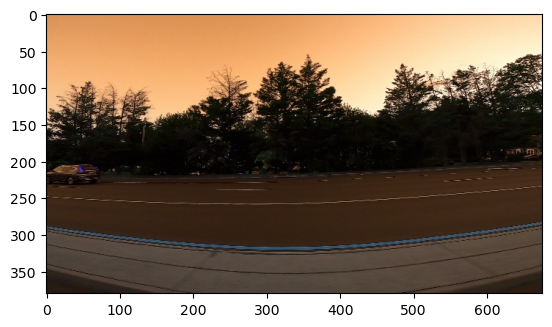

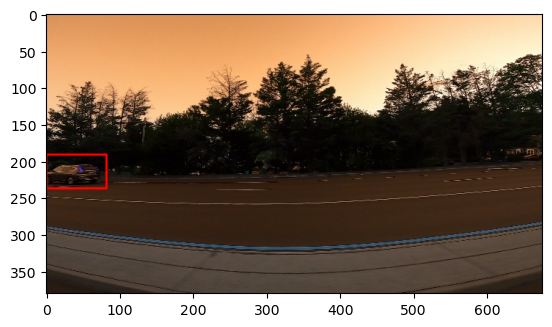

In [9]:
for e,i in enumerate(os.listdir(annot)):
    index = 3
    if e == index:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)

        break

**Let's start**                   
R-CNN object detection system consists of three modules. The first generates category-independent region proposals(through selective search here). These proposals define the set of candidate detections available to our detector. The second module is a large convolutional neural network that extracts a fixed-length feature
vector from each region(here we use VGG 16 whereas original paper works on AlexNet). The third module is a set of class specific linear SVMs. So, let's implient them step by step.
![alt text](https://miro.medium.com/max/2372/0*Sdj6sKDRQyZpO6oH.)

**Selective search**                                                    
Selective Search is a region proposal algorithm used in object detection. It is designed to be fast with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

![alt text](https://arthurdouillard.com/figures/selective_search1.png)

To impliment selective search we use cv2 library, to get more insight of it you can follow this [link](https://pypi.org/project/opencv-python/)

In [10]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Run above cells to get region proposals from selective search algorithm ,performed on a single image to give you more insight of what the algorithm is doing.

**Intersection over union**
Intersection over Union is simply an evaluation metric. Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.          
More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:                                
1.The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
2.The predicted bounding boxes from our model.   
After getting these two we can find there intersection and union area,whih ultimately gives us our IoU.
![alt text](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

In [11]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Preparing training data**
Training data here is prepared according to following scheme:-   
a) Those boxes which have an IoU greater than 0.7 (original paper it's 0.5) are considered as a positive example.   
b) And boxes with relative low IoU 0.3 are taken to be negative examples.  
Number of regions taken here is 30 positive and 30 negative (original paper have 32 and 96 respectively) of size 224x224.
Note- Original paper also talk about warping but as we have resized them already so there is no need of it.

In [12]:
# At the end of below code we will have our train data in these lists
train_images=[]
train_labels=[]

vid_4_30000.csv


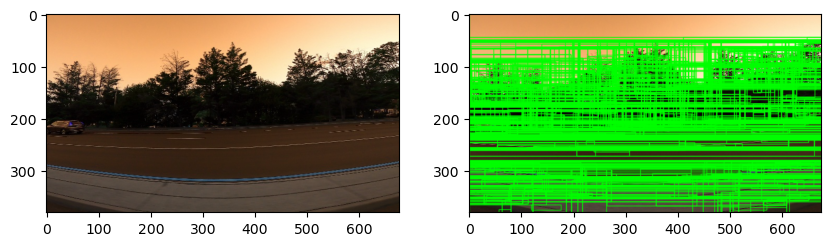

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
for e,i in enumerate(os.listdir(annot)):
    print(i)
    image = cv2.imread(os.path.join(path,filename))
    ax[0].imshow(image)
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imOut = image.copy()
    for i, rect in (enumerate(rects)):
        x, y, w, h = rect
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    # plt.figure()
    ax[1].imshow(imOut)
    break

In [14]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("vid"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image 
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()   
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    print(result)
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 30:       # getting only 30 psoitive examples
                            if iou > 0.80:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <30:      # 30 negatve examples are allowed only
                            if iou < 0.3:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:  
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 vid_4_30000.jpg
[652 124  24  12]
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_30000.jpg
1 vid_4_9660.jpg
[300 308 112  20]
[ 65 196 144  17]
[246 107  31  62]
[270  51  18  15]
[596  95  58  19]
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_9660.jpg
2 vid_4_28840.jpg
[485 131  10  15]
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_28840.jpg
3 vid_4_17440.jpg
[  0 294 676  59]
[146 338  83  10]
[ 54 252 389   8]
[  4  89 151  68]
[321 154  37  10]
[499 342 177  38]
OpenCV(4.8.1) /Users/xperience/GHA-O

KeyboardInterrupt: 

In [ ]:
# conversion of train data into arrays for further training
# X_new = np.array(train_images)
Y_new = np.array(train_labels)
X_new = np.array(train_images)

**Load packages**  
let's load the requied packages

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

**Pre-training**  
We perform tansfer-learning as pre-training here as we are using VGG16 net which is already trained on Imagenet.  We are going to train a binary classifier by making all layers as untrainble except two last.    And then we are going to make a new model which will be stacked on last 2nd output layer.


In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

**Summary of the model and Training**

In [ ]:
model.summary()
model.fit(X_new,Y_new,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

KeyboardInterrupt: 

**Making New Network with svm**

We will start with first creating the dataset for the svm and will then go for the architecture

In [ ]:
svm_image = [];
svm_label = [];

**SVM Dataset**    
For svm dataset we considered all ground truth bounding boxes as positive examples and those which were having an IOU less than 0.3 as false examples to increase the preciseness.

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("vid"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3]) 
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 vid_4_30000.jpg
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_30000.jpg
1 vid_4_9660.jpg
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_9660.jpg
2 vid_4_28840.jpg
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_28840.jpg
3 vid_4_17440.jpg
4 vid_4_21680.jpg
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_21680.jpg
5 vid_4_26460.jpg
OpenCV(4.8.1) 

**SVM Model Architecture**  
First we removed the last layer of the previous model and then added a Dense layer of 2 units at the end.

Now we will see our new Model Summary and we will train it.

In [ ]:
#adding svm to last layer
x = model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()
# final_model.load_weights('my_model_weights.h5')


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 5,verbose = 1,shuffle = True,validation_split = 0.05)

Epoch 1/5
23/23 [==============================] - 110s 5s/step - loss: 18.1011 - accuracy: 0.6863 - val_loss: 3.4704 - val_accuracy: 0.7895
Epoch 2/5
23/23 [==============================] - 119s 5s/step - loss: 3.5653 - accuracy: 0.7941 - val_loss: 3.5807 - val_accuracy: 0.7895
Epoch 3/5
23/23 [==============================] - 114s 5s/step - loss: 2.3801 - accuracy: 0.8011 - val_loss: 1.5093 - val_accuracy: 0.8158
Epoch 4/5
23/23 [==============================] - 171s 8s/step - loss: 1.8827 - accuracy: 0.8487 - val_loss: 1.3651 - val_accuracy: 0.8947
Epoch 5/5
23/23 [==============================] - 157s 7s/step - loss: 1.9905 - accuracy: 0.8375 - val_loss: 2.5575 - val_accuracy: 0.7895


**Ploting  loss and analysing losses**

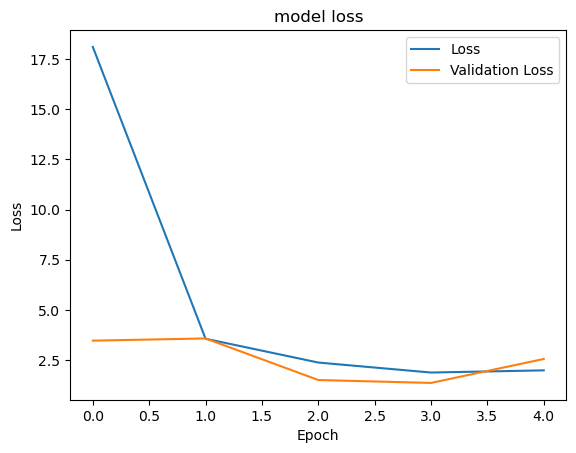

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

**Test Time**  
By Running the below cell we can get the bounding boxes of a particular image and can cherish ourselves.

1/1 [==============================] - 2s 2s/step
0 [[-28.20304    3.809624]]
145 79 113 132
OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

error in vid_4_29560.jpg
1/1 [==============================] - 0s 220ms/step
2 [[ 23.745176 -35.57994 ]]
145 79 113 132
1/1 [==============================] - 0s 154ms/step
3 [[  0.2930707 -28.805979 ]]
145 79 113 132
1/1 [==============================] - 0s 166ms/step
4 [[ 12.9354515 -37.907665 ]]
145 79 113 132
1/1 [==============================] - 0s 151ms/step
5 [[ 23.55441  -48.905144]]
145 79 113 132
1/1 [==============================] - 0s 150ms/step
6 [[ -3.1757998 -18.930355 ]]
145 79 113 132
1/1 [==============================] - 0s 167ms/step
7 [[ 21.443386 -47.257214]]
145 79 113 132
1/1 [==============================] - 0s 144ms/step
8 [[ 18.197247 -39.604813]]
145 79 113 132
1/1 [====

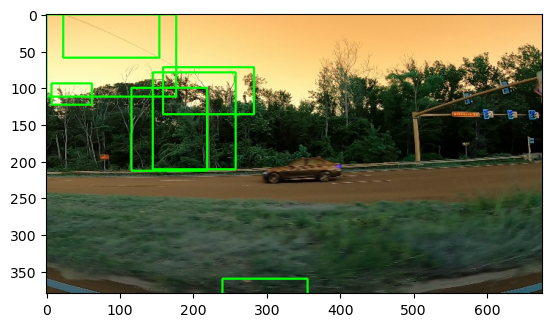

In [ ]:
###########  it's time for test a image    ##########
image = cv2.imread(os.path.join(path,'vid_4_600.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  try:
    if e < 50:
      x,y,w,h = result
      timage = imout[x:x+w,y:y+h]
      resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
      resized = np.expand_dims(resized,axis = 0)
      # print(timage.shape)
      out = final_model.predict(resized)
      print(e,out)
      if(out[0][0]<out[0][1]):
        boxes.append([x,y,w,h])
        count+=1

    for box in boxes:
      x, y, w, h = box
      print(x,y,w,h)
  #     imOut = imOut[x:x+w,y:y+h]
      cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
  # plt.figure()
  except Exception as e:
        print(e)
        print("error in "+filename)
        continue

plt.imshow(imOut);